<a href="https://murmuration-sas.com/" target="_blank">
    <img src="https://murmuration-sas.com/wp-content/uploads/2017/05/Logo-murmuration-vert.png" alt="Murmuration" style="width: 100px" align="right" />
</a>

# Air Quality
______________________

<p style="text-align: right"> Tutorial created by - Murugesh Manthiramoorthi</p>

## Synopsis

[1. Data description](#data_description) <br>
[2. Dependencies](#dependencies) <br>
[3. Import required libraries](#import_libraries) <br>
[4. Open and view zarr](#open_zarr) <br>
[5. Plot map](#plot_map) <br>
[6. Masking xarrays](#masking_xarrays) <br>
[7. Plot the evolution of compound](#plotting_evolution) <br>
[8. Resample the data and plot the evolution of compound](#resample) <br>
[9. Save to netCDF4 file](#save_to_netcdf) <br>
[10. Save externally as geoTIF](#save_as_geotiff) <br>
[11. Convert xarray to pandas dataframe](#convert_to_df) <br>
[12. Sources](#sources) <br> 

## <a id='data_description'></a>1. Data description

- Air quality indicator has a temporal coverage between 21 January 2019 and 27 April 2022.
- The spatial coverage includes the whole European region (west =25.0° W, east=45.0° E, south=30.0° N, north=70.0° N). 
- The data is measured near the ground surface and is available at hourly level. 
- The data has a spatial resolution of 0.1° which corresponds to 10 km near the equator.
- The indicator has 7 sub-indicators (6 compounds and 1 aggregated value)
    - co_conc -  Carbon monoxide - µg/m3
    - no2_conc - Nitrogen dioxide - µg/m3
    - o3_conc - Ozone - µg/m3
    - pm10_conc - Particulate Matter 10 - µg/m3
    - pm2p5_conc - Particulate Matter 2.5 - µg/m3
    - so2_conc - Sulphur dioxide - µg/m3
    - maqi - Murmuration Air Quality Index - no unit
- Murmuration Air Quality Index is an aggregated measutre of all the 6 compounds in the hours. It is a measure which tries to define the combined effect of all the six compounds. 

## <a id='dependencies'></a>2. Dependencies

The following packages are required to run the scripts below.

- xarray
- fsspec
- Pandas
- Plotly

## <a id='import_libraries'></a>3. Import required libraries

In [ ]:
import numpy as np
import xarray as xr
import fsspec
import pandas as pd
import plotly.express as px
import plotly
import warnings
warnings.filterwarnings('ignore')
plotly.offline.init_notebook_mode()

## <a id='open_zarr'></a>4. Open and view zarr

The data is stored on a S3 in the zarr format, which is a cloud optimised format for storing geospatial raster data. It can be opened using the fsspec library. 

In [ ]:
repo = "air_quality_all.zarr"
url = "https://storage.gra.cloud.ovh.net/v1/AUTH_0c2c27fc2c8b4a7d97a35ea0e2911f9b/murmuration-cassini/air-quality/"
ds = xr.open_zarr(fsspec.get_mapper(url + repo))

In [ ]:
ds

## <a id='plot_map'></a>5. Plot map

Select a particular date and a compound to view it in a map. The longitude values are converted from the format (0 to 360) to (-180 to 180) to make the process easy. 

In [ ]:
lon = []
for i in range(len(ds.longitude.values)):
    if ds.longitude.values[i] > 180:
        lon.append(ds.longitude.values[i] - 360)
    else:
        lon.append(ds.longitude.values[i])

ds_gridded = ds.assign_coords({"longitude": lon})

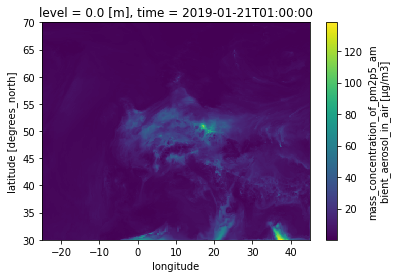

In [5]:
ds_gridded.sel(time = "2019-01-21T01:00:00.000000000")["pm2p5_conc"].plot()

## <a id='masking_xarrays'></a>6. Masking xarrays

Create a mask using where function to replace the value with nan where the condition fails. Use the argument drop to drop those entries

In [ ]:
mask_lon = (ds_gridded.longitude >= -15) & (ds_gridded.longitude <= 15)
ds_masked = ds_gridded.where(mask_lon, drop=True)
ds_masked = ds_masked.sel(latitude = slice(50, 35))

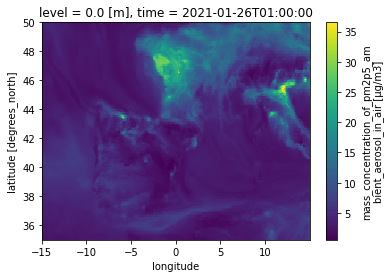

In [7]:
ds_masked["pm2p5_conc"].sel(time = "2021-01-26T01:00:00.000000000").plot()

## <a id='plotting_evolution'></a>7. Plot the evolution of compound

The dataset is rich in both spatial and temporal extension. It is possible to plot the evolution of a specififc compound over time directly using plot function. But in order to have more freedom and to improve the aesthetics of the charts, it can be made using plotly express. To plot the time series evolution, a single point in the grid has to chosen. 

In [ ]:
so2 = ds.sel(latitude = 69.85, longitude = 44.85)["so2_conc"].values.tolist()
so2 = [item for sublist in so2 for item in sublist]
time = list(ds["time"].values)

In [ ]:
fig = px.line(x=time, y=so2, title='Evolution of SO2 - Hourly', labels={'x': 'Time', 'y':'SO2 level'})
fig.show()

## <a id='resample'></a>8. Resample the data and plot the evolution of compound

The data can be resampled to any higher order to time according to the python datetime conventions. For example, "D" or "1D" represents 1 day, "2D" represents two days. 

In [ ]:
so2 = ds.sel(latitude = 69.85, longitude = 44.85).resample(time="M").mean()["so2_conc"].values.tolist()
so2 = [item for sublist in so2 for item in sublist]
time = list(ds.resample(time="M").mean()["time"].values)

In [ ]:
fig = px.line(x=time, y=so2, title='Evolution of SO2 - Monthly', labels={'x': 'Time', 'y':'SO2 level'})
fig.show()

## <a id='save_to_netcdf'></a>9. Save to netCDF4 file

The data can be subsetted nad stored into a netCDF4 file to use it in other tools or softwares. 

In [ ]:
ds_to_nc = ds.sel(time = slice("2019-01-21T00:00:00.000000000", "2019-01-21T23:00:00.000000000"))
ds_to_nc.to_netcdf("ds_to_nc.nc")

## <a id='save_as_geotiff'></a>10. Save externally as geoTIF

The whole data or a part of it can be saved externally into a raster file (geoTIF) to use it in other applications like QGIS, ArcGIS etc. Since here the data is very huge, a part of it has to be selected before saving it tro a geoTIF file. 

In [ ]:
ds_to_save = ds_masked["pm2p5_conc"].sel(time = "2021-01-26T01:00:00.000000000")
ds_to_save

In [ ]:
ds_to_save.rio.to_raster("ds_to_save.tif")

## <a id='convert_to_df'></a>11. Convert xarray to pandas dataframe

Since some of the conputations and charts requires the data to be in a dataframe format, a part or whole of the data can be converted to a daraframe using the following code snippets. 

In [ ]:
mask_lon2 = (ds.longitude >= 2) & (ds.longitude <= 15)
ds_temp = ds.where(mask_lon2, drop=True)
ds_temp = ds_temp.sel(latitude = slice(50, 42))
ds_temp = ds_temp.sel(time = slice("2019-01-21T00:00:00.000000000", "2019-01-23T00:00:00.000000000"))

In [ ]:
ds_to_df = ds_temp.to_dataframe()

In [ ]:
ds_to_df = ds_temp.to_dataframe()
ds_to_df = ds_to_df.reset_index()

In [18]:
ds_to_df.head()

time  level   latitude  longitude     co_conc      maqi   no2_conc  \
0 2019-01-21    0.0  49.950001       2.05  332.387115  1.978060  31.727644   
1 2019-01-21    0.0  49.950001       2.15  326.299194  2.033607  34.509319   
2 2019-01-21    0.0  49.950001       2.25  322.547302  2.041503  35.919926   
3 2019-01-21    0.0  49.950001       2.35  343.761597  2.095805  42.257774   
4 2019-01-21    0.0  49.950001       2.45  367.540009  2.095607  45.039009   

     o3_conc  pm10_conc  pm2p5_conc  so2_conc  
0  13.285834  39.405434   37.023239  4.446577  
1  11.037009  41.180511   37.598778  5.142169  
2   8.295309  41.261116   37.783932  6.098219  
3   4.895029  40.680004   37.257744  7.207802  
4   1.244551  40.124645   36.761532  8.012933

## <a id='sources'></a>12. Sources

- https://docs.xarray.dev/en/stable/index.html
- https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview
- https://plotly.com/python/